In [2]:
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import numpy as np

from matplotlib import pyplot as plt
from importlib import reload 

In [21]:
reload(PS)
beta = 1/16
#els = np.array([0.3, 0.01, 0.01])/beta
els = np.array([0.3, 0.1, 0.1])/beta
ps = PS.PollingSystem(els, beta)
S = np.array([[ 0.        , 11.01635149, 14.27059899],
       [11.01635149,  0.        , 17.132717  ],
       [14.27059899, 17.132717  ,  0.        ]])
#S = 4*np.ones((3,3))

pi = np.array([0.99764782, 0.00135218, 0.001])
#pi = np.array([1/3, 1/3, 1/3])
rp = MRP.RandomRP(pi)
#are we super off with cyclic as well?
#rp = SRP.CyclicRP([0,2,1])
#S = np.array([11.01635149, 14.27059899, 17.132717])
# wait = ps.calc_avg_wait(rp, np.array([S[0,2], S[2,1], S[1,0]]))
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
wait2 = ps._calc_avg_wait_random2(S, pi)
print("Theoreical Wait Time 2: %.4f"%(wait2))
hrs = 2
mins = hrs*60
seconds = mins*60
xt, wt, queues, avg_switching, polling_instants, S_tilde, T = ps.simulate(rp, S, seconds)
print(T)


Theoretical Wait Time: 37.7889
Theoreical Wait Time 2: 39.0370
Emp Factor: 1.428816
Thr: 1.428571
Emp Factor: 1.119941
Thr: 1.111111
Emp Factor: 1.113810
Thr: 1.111111
[[1.09200450e-01 1.92412078e+01 2.62716407e+01]
 [4.83290414e+01 8.19146206e+01 7.49385504e+01]
 [8.63492739e+01 9.26424866e+01 1.19815357e+02]]


In [22]:
np.array([ [ ps._Tij_avg(S, pi, i, j) for j in range(ps.n)] for i in range(ps.n)])

array([[  0.11675964,  19.67474445,  25.96126369],
       [ 66.58809148,  86.1460763 ,  92.43259554],
       [ 90.6404974 , 110.19848221, 116.48500145]])

Empirical Wait Time: 35.3397
Diff: -3.6972 (-0.1046) 
Empirical pi:  [9.97759590e-01 1.32595675e-03 9.14452929e-04]
Lbar MC Emp: 216.3026
lbar mc thr: 252.0786
Emp mc lbar true switch: 216.3026
Emp mc Lbar_0: 0.4977 
Thr mc Lbar_0: 0.5319
Emp Lbar mc at 0 given 0: 0.3663
Thr Lbar mc at 0 given 0: 0.3923
Emp mc Lbar_1: 77.3580 
Thr mc Lbar_1: 106.5314
Emp Lbar mc at 1 given 1: 118.0920
Thr Lbar mc at 1 given 1: 124.0503
Emp mc Lbar_2: 138.4469 
Thr mc Lbar_2: 145.0153
Emp Lbar mc at 2 given 2: 172.8333
Thr Lbar mc at 2 given 2: 167.7384
Empirical lbar:282.672381
Expected Lbar from Little's, Thr Wait: 302.3114
Empirical Average Switching: 0.055314
thr Average Switching: 0.058243
Thr W based on empirical lbar: 35.334048
Empirical average stage duration: 0.1092
Theoretical average stage duration: 0.1165
Emp Observed Average Switch: 12.3446


NameError: name 'pi_toPandNewPi' is not defined

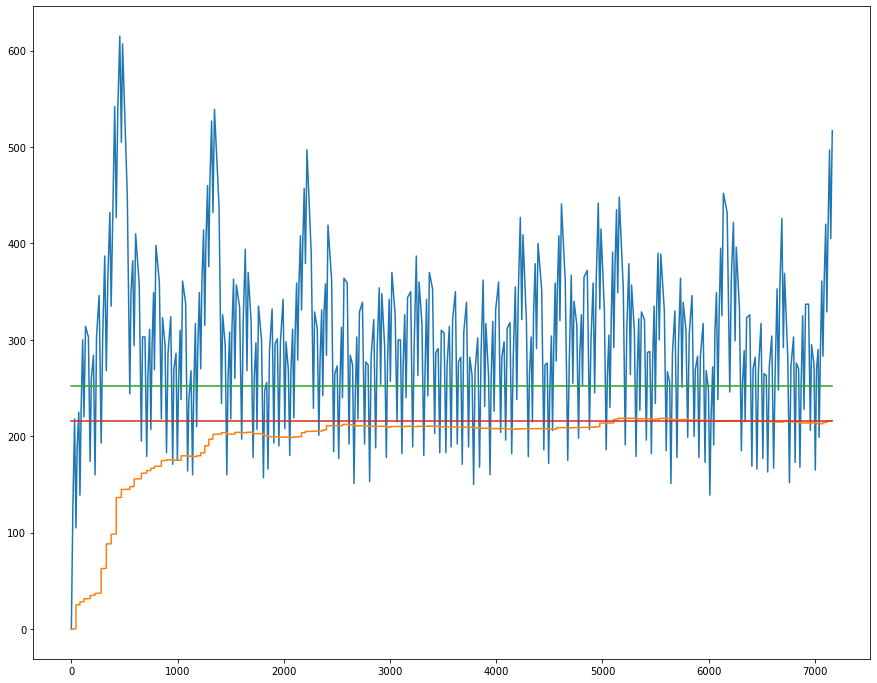

In [23]:
xt = np.array(xt)
print('Empirical Wait Time: %.4f'%(wt[-1][1]))
#     print("Avg Switching: %f"%(avg_switching))
diff = wt[-1][1] - wait2
print("Diff: %.4f (%.4f) "%(diff, diff/wt[-1][1]) )

int_queue_length = 0
average_at_polling = 0
for i in range(len(xt)-1):
    int_queue_length += (xt[i+1][0]-xt[i][0])*sum(xt[i][2:])
Lbar_mc = 0
plgis = np.array(polling_instants)
uni, counts = np.unique(plgis[:,1], return_counts = True)
print("Empirical pi: ", counts/sum(counts))

Lbarmc = 0
sys_lengths = []
sys_lengths_i = []
lbar_i_given_i = np.zeros(3)
sys_lengths_at_true_switch = []
z_prev = -1
true_switches = 0
for i in range(len(plgis)):
    inst = plgis[i,0]
    z = int(plgis[i,1])
    idx = np.where(xt[:,0]==inst)
#     print(idx)
    idx = idx[0][0]
    sys_lengths.append(sum(xt[idx,2:]))
    sys_lengths_i.append(xt[idx,2:])
    lbar_i_given_i[z] += xt[idx, 2+z]
    Lbarmc += sys_lengths[-1]
    if  idx == 0 or (xt[idx,0] - xt[idx-1,0])>0:#not an empty cycle
        sys_lengths_at_true_switch.append(sys_lengths[-1])
        true_switches += 1
    z_prev = z
plt.figure(figsize=(15,12))   
plt.plot(plgis[:,0], sys_lengths)
plt.plot(plgis[:,0], np.cumsum(sys_lengths)/np.arange(1,len(sys_lengths)+1,1) )
print("Lbar MC Emp: %.4f"%(Lbarmc/len(plgis)))
Lmc = ps._LSys_mc_avg(S, pi)
print("lbar mc thr: %.4f"%(Lmc))
plt.plot([0,plgis[-1,0]], [Lmc, Lmc])
#Lmc_no_0 = ps._LSys_mc_avg_no_0(S, pi)
#plt.plot([0,plgis[-1,0]], [Lmc_no_0, Lmc_no_0])

sys_lengths_at_true_switch = np.array(sys_lengths_at_true_switch)
#print(sys_lengths_at_true_switch)
plt.plot([0,plgis[-1,0]], [np.average(sys_lengths_at_true_switch), np.average(sys_lengths_at_true_switch)])
print("Emp mc lbar true switch: %.4f"%(np.average(sys_lengths_at_true_switch)))
#print("Thr mc lbar true switch: %.4f"%(Lmc_no_0) )


sys_lengths_i = np.array(sys_lengths_i)
for i in range(3):
    print("Emp mc Lbar_%d: %.4f "%(i,np.average(sys_lengths_i[:,i]) ))
    print("Thr mc Lbar_%d: %.4f"%(i, ps._Li_mc_avg(S, pi,i)))
    print("Emp Lbar mc at %d given %d: %.4f"%(i, i, lbar_i_given_i[i]/counts[i] ))
    print("Thr Lbar mc at %d given %d: %.4f"%(i, i, ps._Li_mc_avg_at_i(S, pi,i)))
    
lbar = int_queue_length/xt[-1][0]
print("Empirical lbar:%f" %(lbar))
#littles_law_wait
print('Expected Lbar from Little\'s, Thr Wait: %.4f'%(wait*sum(els)))#over all time
#print("Theoretical Lbar: %.4f"%(wait2*sum(els)))


print("Empirical Average Switching: %f"%( avg_switching))
sbar = pi.T@ S @pi
print("thr Average Switching: %f"%(sbar))

print("Thr W based on empirical lbar: %f"%(lbar/sum(els)))

print("Empirical average stage duration: %.4f"%( (plgis[-1,0] - plgis[0,0])/(len(plgis) -1) ))
print("Theoretical average stage duration: %.4f"%(sbar/(1-beta*sum(els))))

print("Emp Observed Average Switch: %.4f"%(S_tilde))
P, p_tilde = pi_toPandNewPi(pi)
thr_S_tilde = np.diag(P@S)@pi
print("Thr Observed Average Swith", thr_S_tilde)
print("\n")

In [33]:
unique, counts = np.unique(sys_lengths_at_true_switch, return_counts = True)
print(np.average(sys_lengths_i[:,1]))
print(unique)
print(counts)
print(len(sys_lengths_at_true_switch))

10.109577414455464
[  0.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  41.  42.  44.  46.  47.  48.  49.  53.  57.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 165. 166. 167. 168. 172. 173. 175. 178.
 179. 182. 184. 185. 186. 187. 189. 213.]
[ 658 2545 7861 2579 3937 3322 1721 5209 3753 4716 1628 6055 6808 1718
 2617 3304 1102 2076 1808 1977   14 2092 1775 4969 1879 1681  827  662
  420  114 1146 

In [13]:
def pi_toPandNewPi(pi):
    n = len(pi)
    #calculate true probability transitions
    P = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j:
                P[i,j] = pi[j]
        P[i,:] /= sum(P[i,:])
    v, M = np.linalg.eig(P.T)

    pi_obs = M[:,0]/sum(M[:,0])
    return P, pi_obs

In [6]:
beta = 1/16
ps = PS.PollingSystem(np.array([0.3, 0.01, 0.01])/beta, beta)

rp = MRP.RandomRP([1/3, 1/3, 1/3])
s = 10
d = 500
for v in [1,2,4,8,100000]:
    S =  np.array([[0, s, d],[s, 0, np.sqrt(d+s**2)],[1.5, np.sqrt(d+s**2), 0]])/v
    wait = ps.calc_avg_wait(rp, S)
    print("Theoretical Wait Time: %f"%(wait))

Theoretical Wait Time: 261.173551
Theoretical Wait Time: 130.594128
Theoretical Wait Time: 65.304417
Theoretical Wait Time: 32.659561
Theoretical Wait Time: 0.017317


In [2]:
#NOTE: decreasing switching time does NOT guarantee decreasing average waiting time

In [7]:
len(polling_instants)

75867

[4.80652778 0.15923611 0.15541667]
[4.8  0.16 0.16]
Empirical average inter arrival: 0.195262
Thr average inter arrival: 0.195312


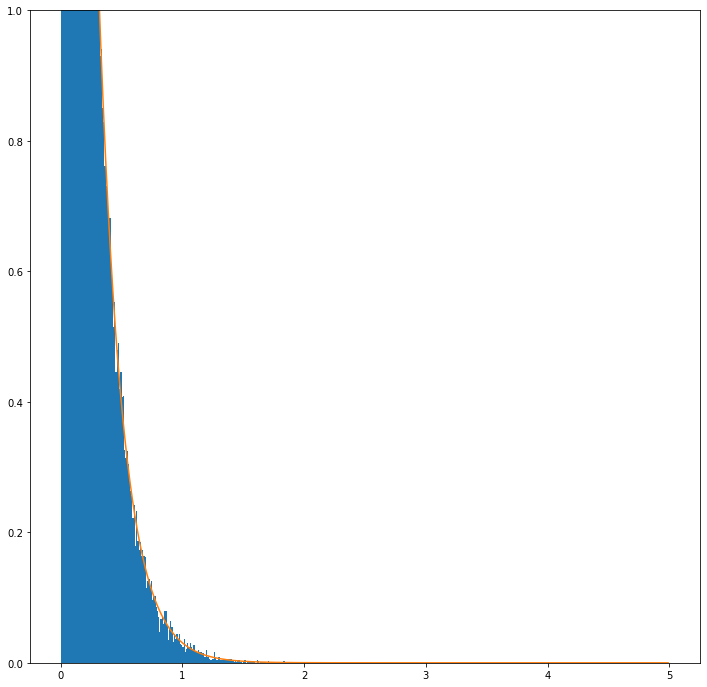

2.2644445728210485
73746


In [38]:
arrivals = ps._generate_arrivals(seconds)
diffs = 0
diffsT = []
types = [0,0,0]
for i in range(len(arrivals)-1):
    diffsT.append(arrivals[i+1][0] - arrivals[i][0])
    diffs += (arrivals[i+1][0] - arrivals[i][0])
    types[arrivals[i][1]] +=1
    
print(np.array(types)/(seconds))
print(els)
inter_arrival = diffs/(len(arrivals)-1)
print("Empirical average inter arrival: %f"%(inter_arrival))
print("Thr average inter arrival: %f"%(1/(sum(els))))
plt.figure(figsize=(12,12))
plt.hist(diffsT, range=(0,5), bins=500, density= True)
x = np.arange(0,5,0.01)
el = sum(els)
y = el*np.exp(-el*x)
plt.plot(x,y)
plt.ylim(0, 1)
plt.show()
print(np.max(diffsT))
print(len(arrivals))

In [8]:
#Scratch Pad
z = np.array([1,2,3,4,5])
z[1:]

array([2, 3, 4, 5])

In [20]:
q=0
samples=len(wt)*20
qs = []
for i in range(samples):
    q = rp.next(q)
    qs.append(q)
    
u, counts = np.unique(qs, return_counts = True)
print(pi)
print(counts/samples)
print(u)

print(pi_toPandNewPi(pi))
print(pi_toPandNewPi(counts/samples))

[0.99764782 0.00135218 0.001     ]
[0.99774425 0.00119132 0.00106443]
[0 1 2]
(array([[0.        , 0.57486247, 0.42513753],
       [0.99899865, 0.        , 0.00100135],
       [0.99864647, 0.00135353, 0.        ]]), array([0.49971206, 0.28755365, 0.21273429]))
(array([[0.        , 0.528125  , 0.471875  ],
       [0.9989343 , 0.        , 0.0010657 ],
       [0.99880742, 0.00119258, 0.        ]]), array([0.49971845, 0.26419536, 0.2360862 ]))


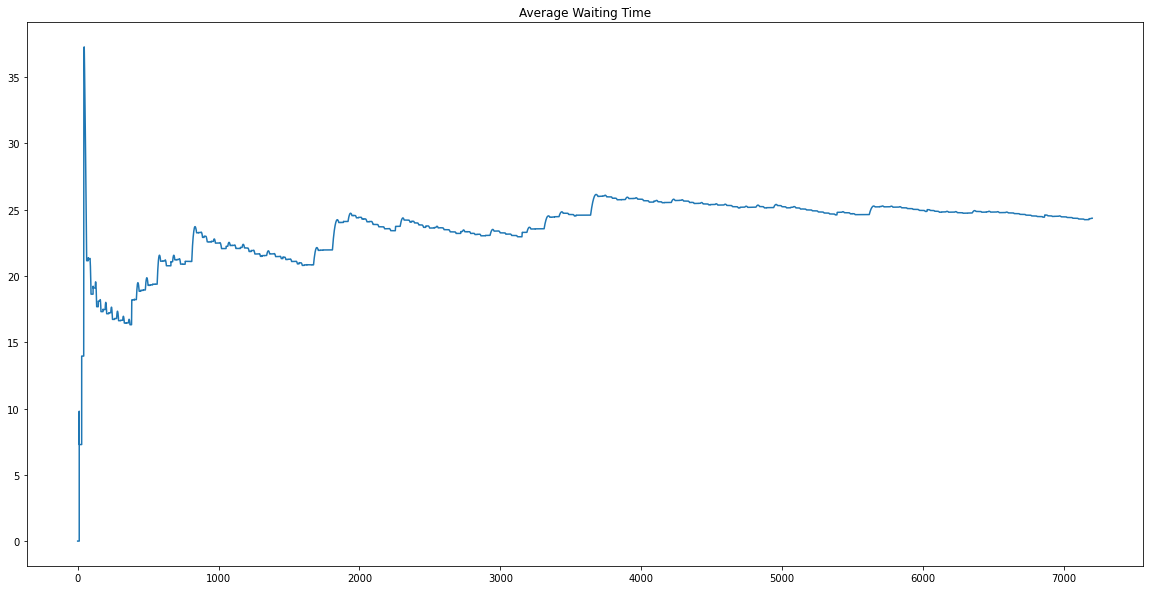

In [6]:
wt = np.array(wt)
fig = plt.figure(figsize=[20,10])
plt.plot(wt[:,0], wt[:,1])
plt.title("Average Waiting Time")
#plt.xlim(6500,8000)
#plt.ylim(12,13)
plt.show()

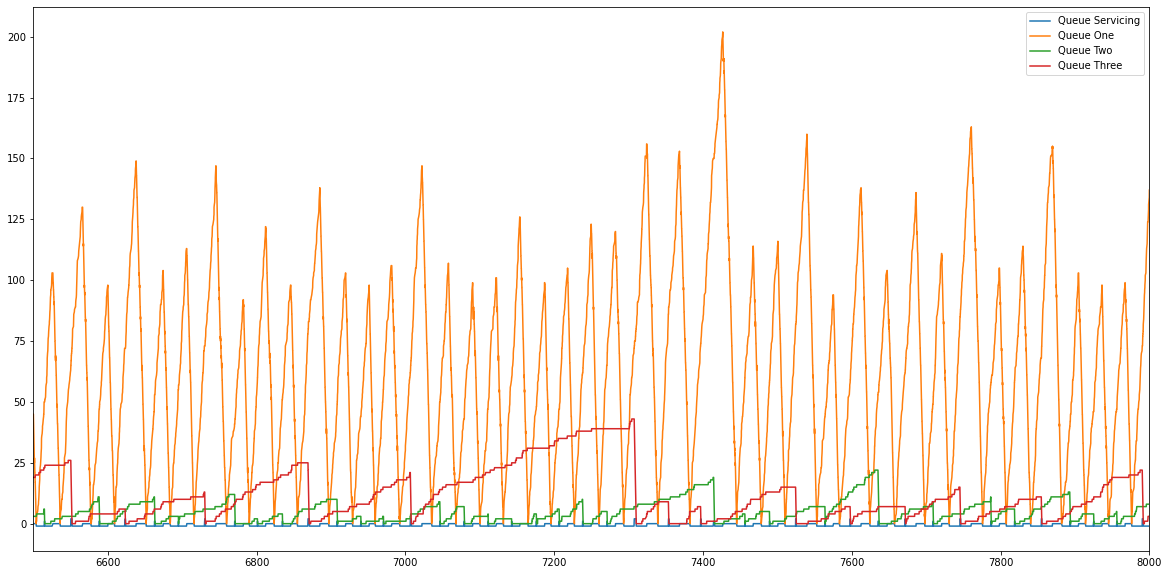

In [22]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0], xt[:,2], label = 'Queue One')
plt.plot(xt[:,0], xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0], xt[:,4], label = 'Queue Three')
plt.legend()
plt.xlim(6500,8000)
# plt.ylim(-2,110)
plt.show()

In [47]:
def tail_avg_wait(queues, tail_start, Ls):
    avg = 0
    for i in range(len(queues)):
        queue = queues[i]
        sst = queue.service_start_times
        upper_i = len(sst) - 1
        lower_i = 0
        while upper_i - lower_i != 1:
            test_i = (upper_i + lower_i)//2
            if sst[test_i] < tail_start:
                lower_i = test_i
            elif sst[test_i] > tail_start:
                upper_i = test_i
            else:
                upper_i = test_i
                lower_i = test_i-1
        q_tail = queue.wait_times[upper_i:]
        avg += Ls[i]*np.mean(q_tail)
    return avg/np.sum(Ls)

tail_avg_wait(queues, 1000, els)

3.465431053486929

In [49]:
res = ps.calc_optiaml_rp(S)
print(res)

     fun: 4.906031021147757
     jac: array([3.89966959, 3.89420819, 3.89767259])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.07410498, 0.0310437 , 0.89485132])


4.906647130845505


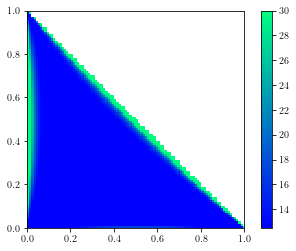

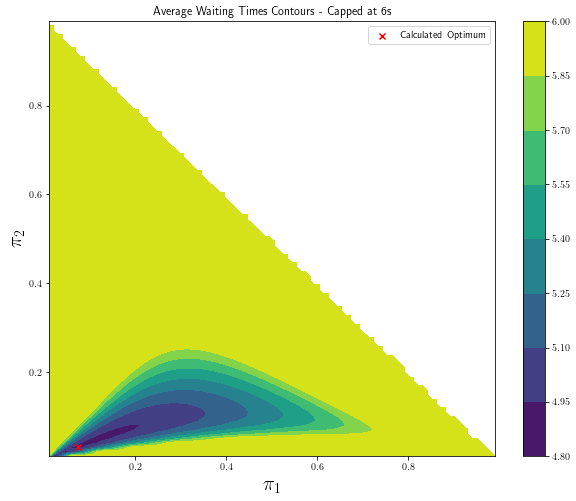

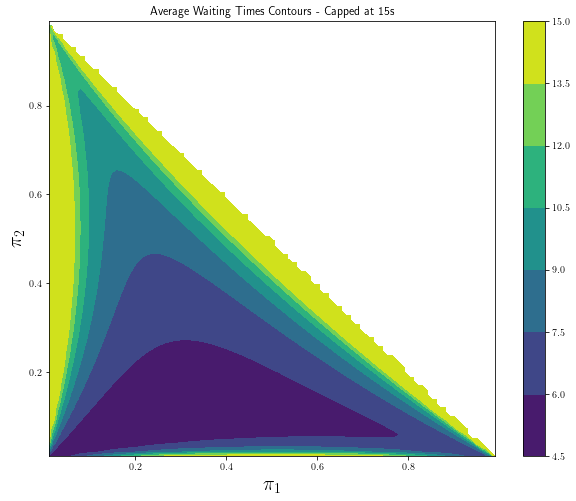

In [50]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

gran = 100
pi1 = np.linspace(1/gran,1-(1/gran), gran)
pi2 = np.linspace(1/gran,1 - (1/gran), gran)
Z = -1*np.Inf*np.ones([gran, gran])

fmin = 10000
for i in range(gran):
    for j in range(gran):
        pi = np.array([pi1[i], pi2[j], 1 - pi1[i] - pi2[j]])
        if pi[2] > 0:
            Z[i,j] = ps._calc_avg_wait_random( pi , S)
            if Z[i,j] < fmin:
                fmin=Z[i,j]
print(fmin)

fig, ax = plt.subplots()
ws = ax.imshow(np.transpose(Z), extent=[0,1,0,1], cmap='winter', interpolation='nearest',
               vmin=12.5,vmax=30, origin='lower')
fig.colorbar(ws)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 6))
#cont = plt.contourf(pi1, pi2, np.minimum(np.log(Z.T), 2.6) )
fig.colorbar(cont)
plt.scatter(res.x[0], res.x[1], label='Calculated Optimum', marker='x', c='r')
plt.legend()
plt.title('Average Waiting Times Contours - Capped at 6s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 15))
fig.colorbar(cont)
plt.title('Average Waiting Times Contours - Capped at 15s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

In [10]:
#Contours are clearly non-convex. We're not dealing with a convex function.
#There doesn't seem to be a good way to verify unimodality, either

In [6]:
wt

[[0.0, 0.0],
 [1.0, 0.0],
 [11.449489742783172, 4.810577276457236],
 [25.449489742783197, 5.996869125095654],
 [33.44948974278322, 6.458916438928569],
 [40.44948974278325, 6.480595434554741],
 [50.89897948556646, 6.495536639019141],
 [55.898979485566485, 6.295950639937349],
 [55.898979485566485, 6.295950639937349],
 [58.348469228349664, 6.295950639937349],
 [65.79795897113286, 5.997687341029218],
 [77.24744871391592, 5.830234607921931],
 [79.69693845669909, 5.830234607921931],
 [86.14642819948214, 5.649665045990662],
 [88.59591794226532, 5.649665045990662],
 [94.04540768504837, 5.49338414176035],
 [109.49489742783143, 5.4298376091362535],
 [117.49489742783132, 5.522395360703529],
 [125.4948974278312, 5.541757494263057],
 [133.4948974278311, 5.496274189275127],
 [145.29285639896372, 5.410620023156765],
 [153.2928563989636, 5.459660619274925],
 [158.2928563989636, 5.459660619274925],
 [161.2928563989635, 5.503703183759251],
 [174.29285639896338, 5.541463198900879],
 [177.29285639896327, 